#### Example

This is an example of the complete process used to generate and plot the data for the paper 'Compare the Pair: Rotated vs. Unrotated Surface Codes at Equal Logical Error Rates'. 

##### Requirements

In [101]:
# pip install stim      # Stim: a stabiliser circuit simulator

In [102]:
# pip install sinter==1.13.0     # Sinter: for bulk sampling of stim circuits

In [103]:
import sinter
import stim

import os
import sys

sys.path.insert(0, 'functions') 
import oscAntgencircuitv2 as oscant
import morefuncs as morefuncs
import com_funcs5 as funcs

# Update with any changes to these files:
from importlib import reload
reload(morefuncs)
reload(funcs)
reload(oscant);


##### Generate surface code circuits:

In [104]:
# Create necessary directories if they don't exist
!rm -rf circuits
!mkdir -p circuits



ps = [0.002, 0.003, 0.004]  # physical error rates
ds = [6, 7, 8, 9]  # distances


# Define CNOT order for x and z type stabilisers. E.g. order 10231203 avoids hook errors in the rotated code and is a worst-case CNOT order unrotated code if doing memory Z experiments (worst-case taken to be most applicable to all states)

x_ro = (3,2,0,1)  # x hook error in rotated code if last two x-type CNOT's are 12, 21, 03 or 30 
z_ro = (3,0,2,1)  # z hook error in rotated code if last two z-type CNOT's are 01, 10, 23 or 32 

# For unrotated, better memory X (Z) performance if the two inner CNOTs are 
x_unro = (1,0,2,3) 
z_unro = (1,2,0,3)  

ro_CNOT_order = int(''.join(map(str, x_ro + z_ro)))
unro_CNOT_order = int(''.join(map(str, x_unro + z_unro)))

for ro in ['ro', 'unro']: # rotation

    x, z = (x_ro, z_ro) if ro == 'ro' else (x_unro, z_unro)

    for b in 'xz': # basis of memory experiment (preserving + logical or 0 logical)
        for p in ps:
            for d in ds:
                thecircuit = oscant.generate_circuit(
                    f"surface_code:{ro}tated_memory_{b}",
                    rounds=3*d, 
                    distance=d, 
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=p,
                    before_measure_flip_probability=p, 
                    before_round_data_depolarization=p,
                    x_cnot_order = x,
                    z_cnot_order = z,
                    exclude_other_basis_detectors = True, # still perform the opposite basis' stabiliser measurements but no need to add their detections to the graph which will be given to PyMatching as it is not a correlated decoder
                )
                
                morefuncs.add_idling_errors_and_save_circuit(thecircuit, b, d, p, ro, x, z)



                ## Optional displays of circuit (recommended to comment out if generating many circuits)
                
                # display(thecircuit.without_noise().diagram("detslice-with-ops-svg", tick=range(0,9))) # note only one stab. type detecting region appears if exlude_other_basis_detectors above is True, though the operations will still be done to measure that stabiliser
                # display(thecircuit.without_noise().diagram("detslice-svg", tick=range(0,14)))
                # display(thecircuit.without_noise().diagram('timeline-svg'))
                # display(thecircuit.diagram('timeline-svg'))
                # print(repr(thecircuit))

##### Sample the circuits:

In [105]:
%%bash
rm collected_stats/example_stats.csv 2>/dev/null

# 'processes' is number of processor cores available
sinter collect \
    --processes 4 \
    --circuits circuits/*.stim \
    --metadata_func "sinter.comma_separated_key_values(path)" \
    --decoders pymatching \
    --max_shots 100_000 \
    --max_errors 100_000 \
    --save_resume_filepath collected_stats/example_stats.csv

Starting 4 workers...
48 cases left:
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=z,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=z,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=unro}
48 cases left:
    pymatching processes=1  ~core_mins_left=None    shots_left=100000   errors_left=100000  {b=x,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=x,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=unro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=z,d=6,idl=y,o=10231203,p=0.002,r=3d,ro=ro}
    pymatching processes=1  ~core_mins_left=None    (initializing...) {b=z,d=6,idl=y,o=10231203,p=0.002,r=3d

In [106]:
# # combine and print the stats (optional):
# !sinter combine collected_stats/example_stats.csv

##### Threshold plots: $p_L$ vs. $p$

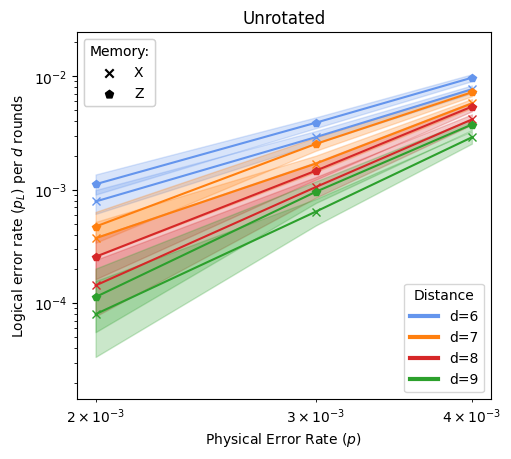

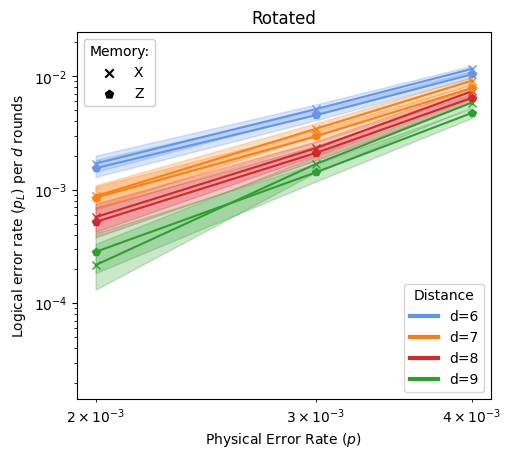

In [107]:
# python:
reload(funcs)

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')

funcs.plot_thresholds(mylist, ro_CNOT_order, unro_CNOT_order)

##### Fit to scaling function $p_L = \alpha ( p / \beta)^{\gamma d + \delta}$

<IPython.core.display.Math object>


distances = combined

unro z 10231203

    α = 0.041 ± 0.021
    β = 0.00636 ± 0.00007
    γ = 0.629 ± 0.095
    δ = 0.59 ± 0.72


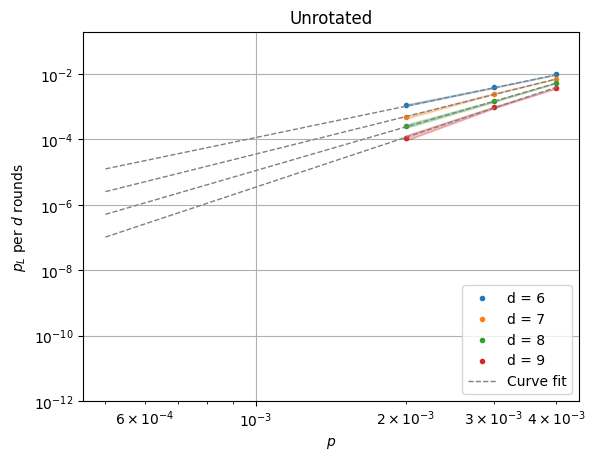


ro z 10231203

    α = 0.050 ± 0.024
    β = 0.00716 ± 0.00002
    γ = 0.438 ± 0.062
    δ = -0.12 ± 0.47


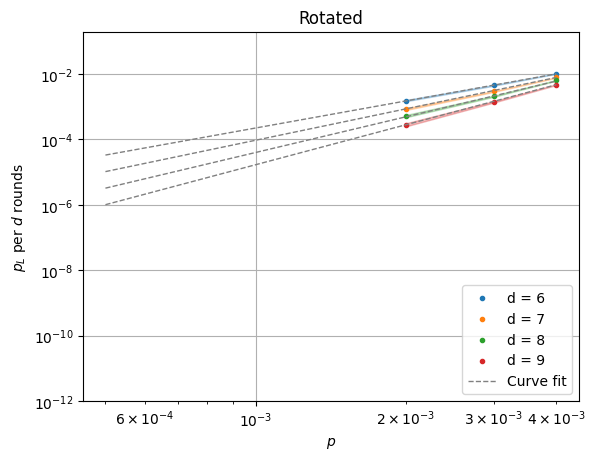

In [108]:
reload(funcs)

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')

distances = 'combined' # choices are 'odd', 'even' or 'combined'
b = 'z' # choices are x or z 

funcs.fit_scaling_and_plot(mylist, distances, b, ro_CNOT_order, unro_CNOT_order)

##### Plot as $p_L$ vs. $\sqrt{n}$

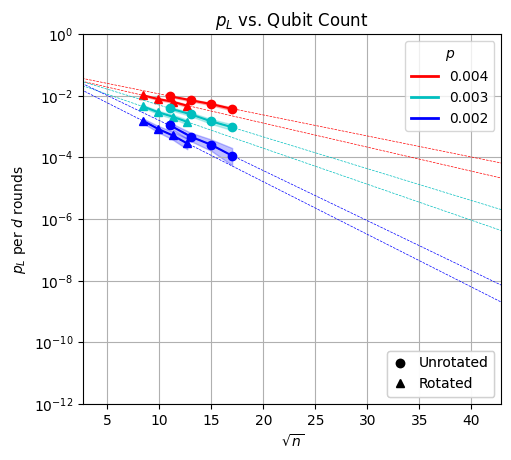

In [109]:
reload(funcs)

b = 'z' 
ps = ps

mylist = sinter.stats_from_csv_files(f'collected_stats/example_stats.csv')
# 
funcs.plot_pL_vs_qubit_count(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Plot 'teraquop' count :$\ $ the number of qubits required to reach $p_L = 10^{-12}$

<IPython.core.display.Math object>

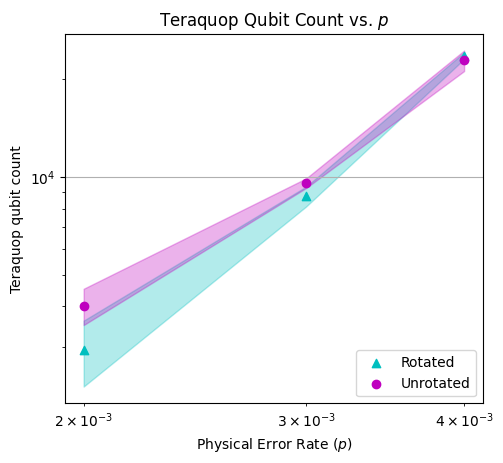

In [110]:
reload(funcs)

b = 'x' 

funcs.plot_teraquop(mylist, b, ro_CNOT_order, unro_CNOT_order, optional_plot = False)

##### Plot ratios of qubit counts vs. $p_L$

This is the projected number of qubits used by the rotated surface code divided by the number of qubits used by the unrotated surface code to achieve the same $p_L$

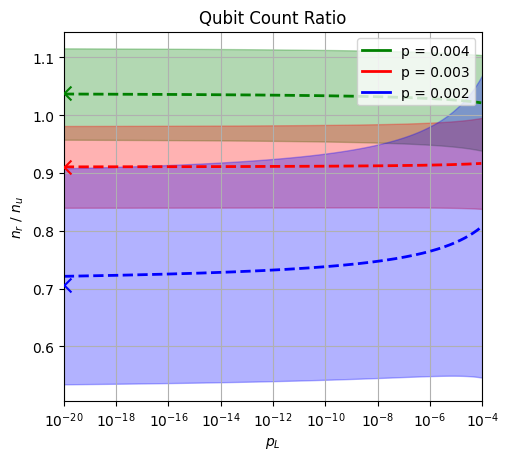

In [111]:
reload(funcs)

funcs.plot_ratio(mylist, b, ro_CNOT_order, unro_CNOT_order)

##### Memory time vs. $\sqrt{n}$

This is a reformulation of the $p_L$ vs. $\sqrt{n}$ plots above, converting the $p_L$ per $d$ rounds to be the length of time (assuming one stabiliser measurement cycle take a microsecond) before $p_L$ over the entire shot of the memory experiment equals $p$.

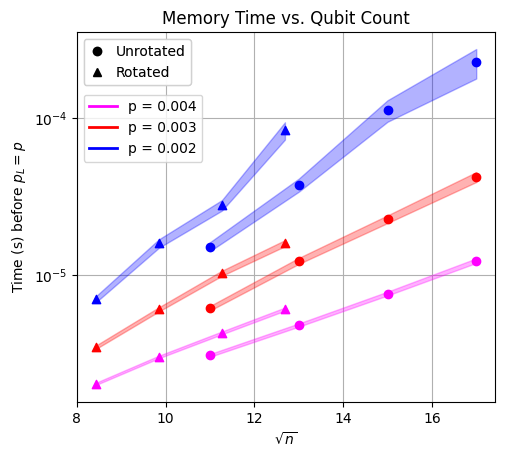

In [112]:
reload(funcs)

b = 'x'

funcs.plot_memory_times(mylist, b, ro_CNOT_order, unro_CNOT_order)